# --- Imports ---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_absolute_error, accuracy_score, confusion_matrix
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import random
import pandas as pd

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE



# --- Load & Preprocess Dataset ---


In [2]:
# Load dataset
df = pd.read_csv('Injury_Risk_Prep3.csv')

# Check the columns of the dataset
print("Columns in DataFrame:", df.columns)

# Drop non-numeric columns that can't be processed easily (like 'Player')
df.drop(columns=['Player ID','Player'], inplace=True)

# Convert 'Season' to a numeric value (just take the first part of the season)
df['Season'] = df['Season'].apply(lambda x: int(x.split('/')[0]))

# Convert 'Date of Injury' and 'Date of return' to numeric values
df['Date of Injury'] = pd.to_datetime(df['Date of Injury'])
df['Date of return'] = pd.to_datetime(df['Date of return'])
df['Days_until_return'] = (df['Date of return'] - df['Date of Injury']).dt.days

# Drop original 'Date of Injury' and 'Date of return' columns
df.drop(columns=['Date of Injury', 'Date of return'], inplace=True)

# Set targets
y_classification = df['Injury_Grouped_Encoded'].astype(int)  # Use the 'Injury_Grouped_Encoded' directly for classification
y_regression = df['Recovery Time(days)']  # 'Recovery Time(days)' for regression

# Drop columns that are not needed for model training
df.drop(columns=['Injury_Grouped','Injury'], inplace=True)

# --- Normalize numeric columns ---
# Select only numeric columns for scaling
# Identify the target columns (replace 'target_col' with your actual target column names)
target_cols = ['Recovery Time(days)', 'Injury_Grouped_Encoded']  # Example target columns

# Select numeric columns excluding the target variables
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Remove target variables from numeric columns to avoid scaling them
numeric_cols = [col for col in numeric_cols if col not in target_cols]

# Initialize the scaler
scaler = StandardScaler()

# Scale only the numeric columns (excluding the target variables)
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])


# --- Train-test split for Classification and Regression ---
# Train-test split for classification
X_train, X_test, y_train_class, y_test_class = train_test_split(
    df, y_classification, test_size=0.2, stratify=y_classification, random_state=42
)

# Train-test split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    df, y_regression, test_size=0.2, random_state=42
)

# Train-test split for scaled classification
X_train_scaled, X_test_scaled, y_train_class_scaled, y_test_class_scaled = train_test_split(
    df_scaled, y_classification, test_size=0.2, stratify=y_classification, random_state=42
)

# Train-test split for scaled regression
X_train_scaled_reg, X_test_scaled_reg, y_train_reg_scaled, y_test_reg_scaled = train_test_split(
    df_scaled, y_regression, test_size=0.2, random_state=42
)


Columns in DataFrame: Index(['Player ID', 'Player', 'Nationality', 'Team Name', 'Position', 'Age',
       'Season', 'Injury', 'Date of Injury', 'Date of return',
       'Recovery Time(days)', 'total_minutes_played', 'matches_played',
       'total_yellow_cards', 'total_red_cards', 'Injury_Grouped',
       'Injury_Grouped_Encoded', 'fatigue_level'],
      dtype='object')


In [3]:
# Assuming 'injury_grouped_encoded' is your encoded version of the 'Injury' column
X_train['Injury'] = X_train['Injury_Grouped_Encoded']
X_test['Injury'] = X_test['Injury_Grouped_Encoded']

# Drop the original 'Injury' column if you no longer need it
X_train = X_train.drop(columns=['Injury_Grouped_Encoded'])
X_test = X_test.drop(columns=['Injury_Grouped_Encoded'])


# Assuming 'injury_grouped_encoded' is your encoded version of the 'Injury' column
X_train_reg['Injury'] = X_train_reg['Injury_Grouped_Encoded']
X_test_reg['Injury'] = X_test_reg['Injury_Grouped_Encoded']

# Drop the original 'Injury_Grouped_Encoded' column if no longer needed
X_train_reg = X_train_reg.drop(columns=['Injury_Grouped_Encoded'])
X_test_reg = X_test_reg.drop(columns=['Injury_Grouped_Encoded'])



# --- Classification Models: XGBoost / Random Forest / ANN ---


In [4]:
param_grid_class = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2]
}

# XGBoost Classifier
xgb_class = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_classification)), random_state=42, use_label_encoder=False)
random_search_xgb = RandomizedSearchCV(xgb_class, param_distributions=param_grid_class, n_iter=10, scoring='accuracy', cv=5, verbose=0, random_state=42)
random_search_xgb.fit(X_train_scaled, y_train_class_scaled)
best_xgb_class = random_search_xgb.best_estimator_

# Random Forest Classifier
# Define parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10, 20],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 10],  # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False],  # Whether to use bootstrap sampling
    'class_weight': ['balanced', None],  # Adjust class weights to deal with imbalanced data
}

# Create RandomForestClassifier model
rf_class = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV for RandomForest
random_search_rf = RandomizedSearchCV(rf_class, param_distributions=param_grid_rf, n_iter=20, 
                                      scoring='accuracy', cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model for RandomForest
random_search_rf.fit(X_train, y_train_class)

# Best RandomForest model and its performance
best_rf_class = random_search_rf.best_estimator_
print(f"Best RandomForest Classifier Hyperparameters: {random_search_rf.best_params_}")

# --- Cross-validation for Best RandomForest Model ---
cv_scores_rf = cross_val_score(best_rf_class, X_train, y_train_class, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy Scores for RandomForest Classifier: {cv_scores_rf}")
print(f"Mean Accuracy: {cv_scores_rf.mean()}")


# ANN Model
model_ann = Sequential([
    Dense(512, kernel_regularizer=l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout to prevent overfitting
    Dense(256, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dense(len(np.unique(y_train_class_scaled)), activation='softmax')
])

model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_history = model_ann.fit(X_train_scaled, y_train_class_scaled, epochs=50, batch_size=16, validation_split=0.2, verbose=0,
                            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RandomForest Classifier Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'class_weight': 'balanced', 'bootstrap': False}
Cross-validation Accuracy Scores for RandomForest Classifier: [0.78461538 0.828125   0.84375    0.828125   0.859375  ]
Mean Accuracy: 0.8287980769230769


# --- Regression Models: XGBoost / LightGBM / RNN ---


In [5]:
param_grid_reg = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoost Regressor
xgb_reg = XGBRegressor()
random_search_reg = RandomizedSearchCV(xgb_reg, param_distributions=param_grid_reg, n_iter=10, scoring='neg_mean_absolute_error', cv=5, verbose=0, random_state=42)
random_search_reg.fit(X_train_scaled_reg, y_train_reg_scaled)
best_xgb_reg = random_search_reg.best_estimator_

# LightGBM Regressor
lgb_reg = LGBMRegressor(n_estimators=150, learning_rate=0.03, num_leaves=31, subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1)
lgb_reg.fit(X_train_scaled_reg, y_train_reg_scaled)

# RNN Model
X_rnn = X_train_scaled_reg.values.reshape((X_train_scaled_reg.shape[0], 1, X_train_scaled_reg.shape[1]))
X_test_rnn = X_test_scaled_reg.values.reshape((X_test_scaled_reg.shape[0], 1, X_test_scaled_reg.shape[1]))

rnn_model = Sequential()
rnn_model.add(Dense(128, activation='relu', input_shape=(1, X_train_scaled_reg.shape[1])))
rnn_model.add(Dropout(0.3))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dense(1))

rnn_model.compile(optimizer='adam', loss='mae', metrics=['mae'])
rnn_history = rnn_model.fit(X_rnn, y_train_reg_scaled, epochs=50, batch_size=16, validation_split=0.2, verbose=0,
                            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])



# --- Model Evaluation: Classification ---



XGBoost Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00         3

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



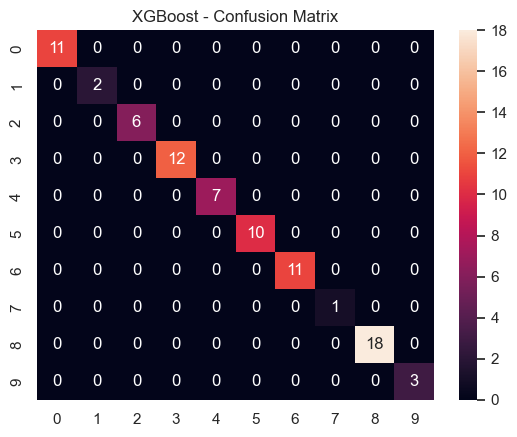


RandomForest Accuracy: 0.8148
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.00      0.00      0.00         2
           2       0.86      1.00      0.92         6
           3       0.75      0.75      0.75        12
           4       1.00      0.43      0.60         7
           5       1.00      0.90      0.95        10
           6       0.83      0.91      0.87        11
           7       1.00      1.00      1.00         1
           8       0.90      1.00      0.95        18
           9       0.33      0.33      0.33         3

    accuracy                           0.81        81
   macro avg       0.74      0.71      0.72        81
weighted avg       0.82      0.81      0.81        81



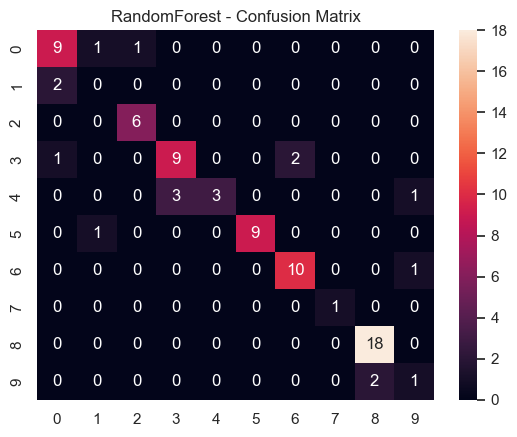

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

ANN Accuracy: 0.7407
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       0.00      0.00      0.00         2
           2       0.50      0.17      0.25         6
           3       0.60      0.75      0.67        12
           4       0.40      0.29      0.33         7
           5       0.82      0.90      0.86        10
           6       0.77      0.91      0.83        11
           7       0.00      0.00      0.00         1
           8       0.86      1.00      0.92        18
           9       0.00      0.00      0.00         3

    accuracy                           0.74        81
   macro avg       0.47      0.50      0.47        81
weighted avg       0.66      0.74      0.69        81



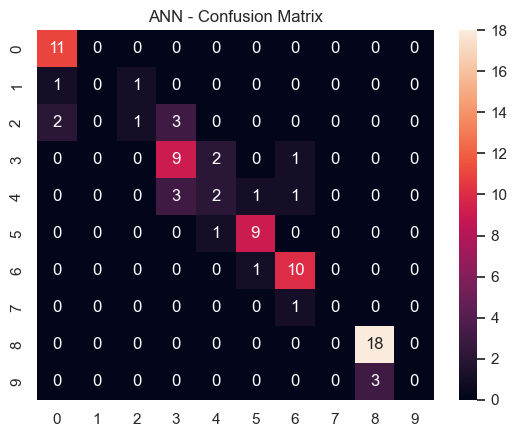

In [6]:
models_class = {
    'XGBoost': best_xgb_class,
    'RandomForest': best_rf_class,
    'ANN': model_ann
}

for name, model in models_class.items():
    if name == 'ANN':
        y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
        y_true = y_test_class_scaled
    elif name == 'XGBoost':
        y_pred = model.predict(X_test_scaled)
        y_true = y_test_class_scaled
    elif name == 'RandomForest':
        y_pred = model.predict(X_test)
        y_true = y_test_class
    else:
        continue  

    acc = accuracy_score(y_true, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'{name} - Confusion Matrix')
    plt.show()


In [7]:
y_classification = df['Injury_Grouped_Encoded'].astype(int)


In [8]:
# Count how many samples per class
class_counts = y_classification.value_counts().sort_index()
print("\nSample count per class in Injury_Grouped_Encoded:")
print(class_counts)



Sample count per class in Injury_Grouped_Encoded:
Injury_Grouped_Encoded
0    55
1     9
2    32
3    57
4    34
5    48
6    57
7     6
8    88
9    16
Name: count, dtype: int64


# --- Model Evaluation: Regression ---



XGBoost MAE: 0.3513


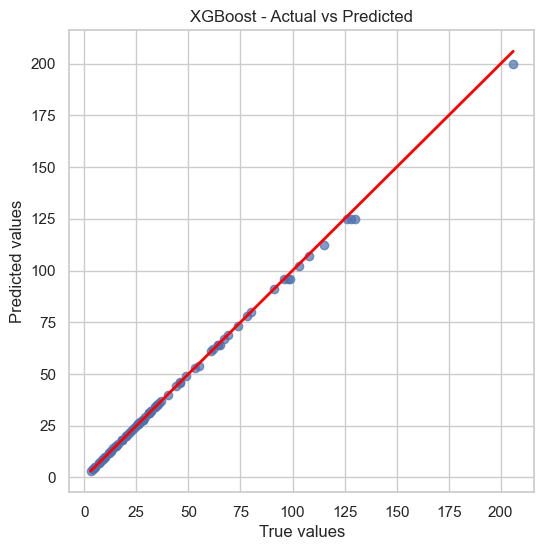


LightGBM MAE: 2.6945


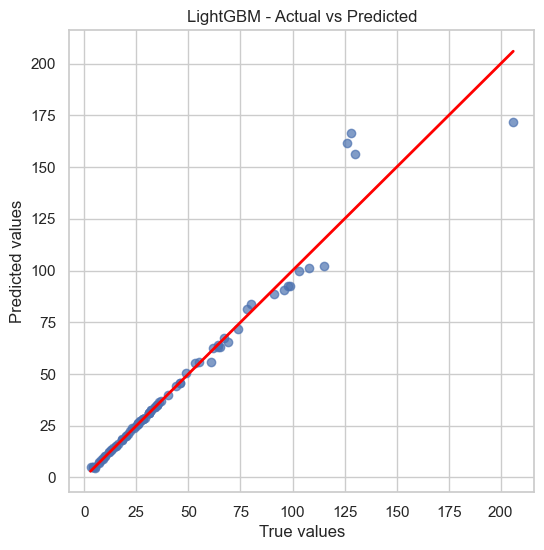

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

RNN MAE: 0.3528


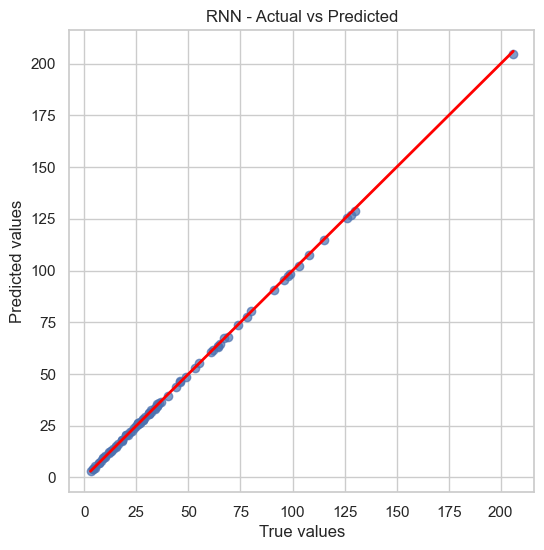

In [9]:
models_reg = {"XGBoost": best_xgb_reg, "LightGBM": lgb_reg, "RNN": rnn_model}

for name, model in models_reg.items():
    if name == 'RNN':
        y_pred_reg = model.predict(X_test_rnn).flatten()
    else:
        y_pred_reg = model.predict(X_test_scaled_reg)

    mae = mean_absolute_error(y_test_reg_scaled, y_pred_reg)
    print(f"\n{name} MAE: {mae:.4f}")

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_reg_scaled, y_pred_reg, alpha=0.7)
    plt.plot([y_test_reg_scaled.min(), y_test_reg_scaled.max()], [y_test_reg_scaled.min(), y_test_reg_scaled.max()],
             color='red', lw=2)
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title(f'{name} - Actual vs Predicted')
    plt.show()

# --- Model Evaluations ---



--- Classification Model Comparison ---
RandomForest Accuracy: 0.8148
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
ANN Accuracy: 0.7407

--- Regression Model Comparison ---
XGBoost -> MAE: 0.3513, R²: 0.9991
LightGBM -> MAE: 2.6945, R²: 0.9547
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RNN -> MAE: 0.3528, R²: 0.9998


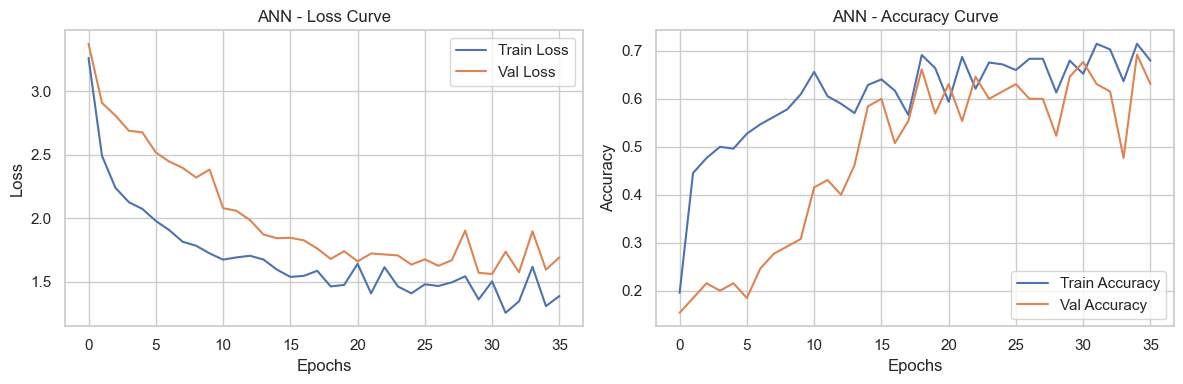

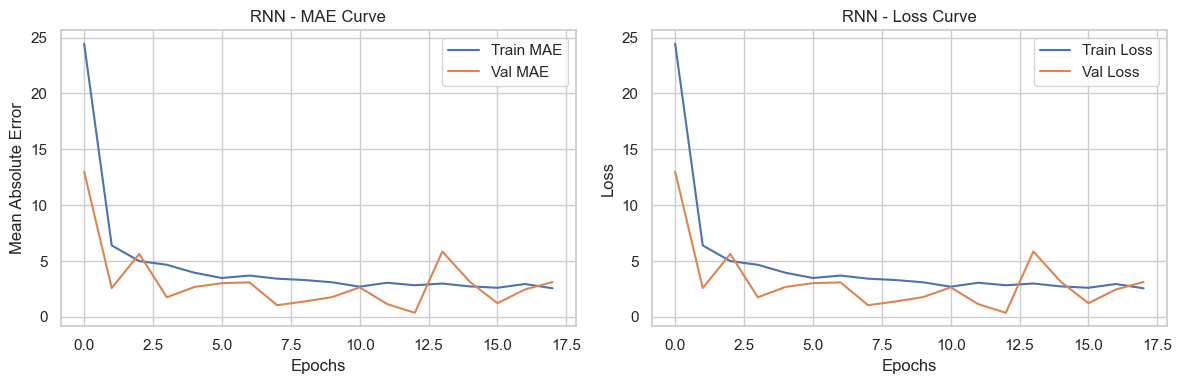

In [10]:
# --- Compare All Classification Models and Select Best ---
models_class = {
    'RandomForest': best_rf_class,
    'ANN': model_ann
    # 'XGBoost': best_xgb_class  # Excluded due to overfitting
}

best_class_model = None
best_class_score = 0
print("\n--- Classification Model Comparison ---")
for name, model in models_class.items():
    if name == 'ANN':
        y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
        y_true = y_test_class_scaled
    elif name == 'RandomForest':
        y_pred = model.predict(X_test)
        y_true = y_test_class

    acc = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

    if acc > best_class_score:
        best_class_score = acc
        best_class_model = model



# --- Compare All Regression Models and Select Best ---
best_reg_model = None
best_reg_r2 = float("inf")

print("\n--- Regression Model Comparison ---")
for name, model in models_reg.items():
    if name == 'RNN':
        y_pred = model.predict(X_test_rnn).flatten()
    else:
        y_pred = model.predict(X_test_scaled_reg)

    mae = mean_absolute_error(y_test_reg_scaled, y_pred)
    r2 = r2_score(y_test_reg_scaled, y_pred)
    print(f"{name} -> MAE: {mae:.4f}, R²: {r2:.4f}")

    if r2 < best_reg_r2:
        best_reg_r2 = r2
        best_reg_model = model


# --- Plot ANN Loss & Accuracy ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ann_history.history['loss'], label='Train Loss')
plt.plot(ann_history.history['val_loss'], label='Val Loss')
plt.title("ANN - Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ann_history.history['accuracy'], label='Train Accuracy')
plt.plot(ann_history.history['val_accuracy'], label='Val Accuracy')
plt.title("ANN - Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot RNN Loss and MAE Curves ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['mae'], label='Train MAE')
plt.plot(rnn_history.history['val_mae'], label='Val MAE')
plt.title("RNN - MAE Curve")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Val Loss')
plt.title("RNN - Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# --- Predictions ---


In [11]:
# --- Load Injury Mapping from CSV ---
simplified_injury_mapping = pd.read_csv('simplified_injury_mapping.csv')

# --- Prediction: Classification & Regression for a Single Sample ---
# Select sample depending on the classification model type
if best_class_model == model_ann:
    sample_class = X_test_scaled.sample(n=1, random_state=random.randint(0, 10000))
    sample_for_reg = X_test_scaled_reg.loc[sample_class.index]  # Regression uses matching scaled features
    classification_pred = best_class_model.predict(sample_class)
    classification_pred = np.argmax(classification_pred, axis=1)
    classification_prob = best_class_model.predict(sample_class)

elif best_class_model == best_rf_class:
    rand_idx = random.randint(0, len(X_test) - 1)
    sample_class = X_test.iloc[[rand_idx]]
    sample_for_reg = X_test_scaled_reg.iloc[[rand_idx]]
  # Match by index to keep same sample
    classification_pred = best_class_model.predict(sample_class)
    classification_prob = best_class_model.predict_proba(sample_class)

# --- Map prediction to injury label ---
# --- Get top 3 predicted classes and their probabilities ---
top3_indices = np.argsort(classification_prob[0])[::-1][:3]  # Indices of top 3 predictions
top3_probs = classification_prob[0][top3_indices]  # Probabilities of top 3

print("\nTop 3 Predicted Injury Types:")
for idx, (i, prob) in enumerate(zip(top3_indices, top3_probs), start=1):
    injury_label = simplified_injury_mapping[
        simplified_injury_mapping['Encoded Value'] == i
    ]['Injury Category'].values[0]
    print(f"{idx}. {injury_label} ({prob * 100:.2f}%)")


# --- Regression prediction (Recovery Time) ---
if best_reg_model.__class__.__name__ == 'Sequential':  # Assuming RNN is a Keras Sequential model
    sample_rnn = sample_for_reg.values.reshape((1, 1, sample_for_reg.shape[1]))  # RNN input format
    recovery_time_pred = best_reg_model.predict(sample_rnn)
else:
    recovery_time_pred = best_reg_model.predict(sample_for_reg)

predicted_recovery_time = recovery_time_pred[0]
print(f"Predicted Recovery Time (in days): {predicted_recovery_time:.0f} days")



Top 3 Predicted Injury Types:
1. Knee/Leg (56.25%)
2. Thigh/Hamstring (12.55%)
3. Groin/Hip (6.21%)
Predicted Recovery Time (in days): 9 days
